# Traffic example

Import the necessary packages.

In [10]:
using ConservationLawsParticles
using RecursiveArrayTools, DifferentialEquations, Plots

## Define the model

- The external velocity is constant and directed to the right.
- The interaction is repulsive at small scales and attractive at long range.
- The mobility models total congestion when the density reaches $1$.

$$
\begin{aligned}
V(x) &= 1 & W(x) &= 2 \left( e^{|x|/4} + e^{-2|x|}\right) \\
\mathop{\mathrm{mob}}(\rho) &= (1-\rho)_+ &
W'(x) &= 2 \mathop{\mathrm{sign}}(x) \left( \frac{e^{|x|/4}}4 - 2e^{-2|x|} \right)
\end{aligned}
$$

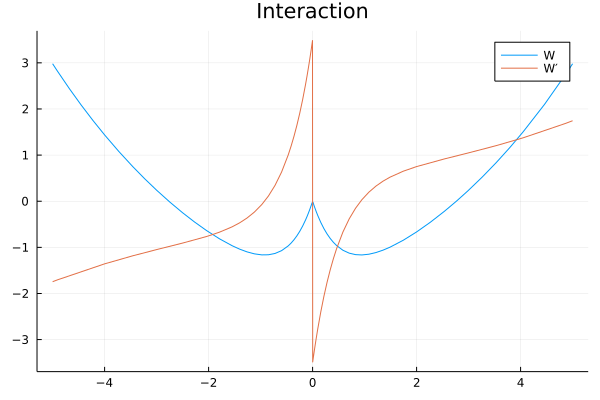

In [11]:
@time_independent V(x) = 1.
@time_independent W(x) = 2(exp(abs(x)/4) + exp(-2abs(x))) - 4
@time_independent W′(x) = 2sign(x) * (exp(abs(x)/4)/4 - 2exp(-2abs(x)))
mob(ρ) = max(1 - ρ, 0)

smodel = SampledModel((V,), ((W′,),), (mob,))
imodel = IntegratedModel((V,), ((W,),), (mob,))

plot(W, -5, 5, title="Interaction", label="W")
plot!(W′, -5, 5, label="W′")

## Define the ODE problem and the initial conditions

The initial condition approximates $\rho_0 = 1_{[-1,-1/2]} + 1_{[1/2,1]}$.

In [19]:
n = 25
x0 = ArrayPartition(vcat(range(-1, -.5, length=n), range(.5, 1, length=n)))

tspan = (0., 5.)

sprob = ODEProblem(velocities_gen!, x0, tspan, smodel)
iprob = ODEProblem(velocities_gen!, x0, tspan, imodel)
;

## Solve the ODE

In [20]:
abstol, reltol = 1e-7, 1e-7

@time ssol = solve(sprob, BS5(); abstol=abstol, reltol=reltol)
@time isol = solve(iprob, BS5(); abstol=abstol, reltol=reltol)

length.((ssol, isol))

  0.015444 seconds (1.96 k allocations: 646.656 KiB)
  0.011731 seconds (3.02 k allocations: 1.132 MiB)


(50, 50)

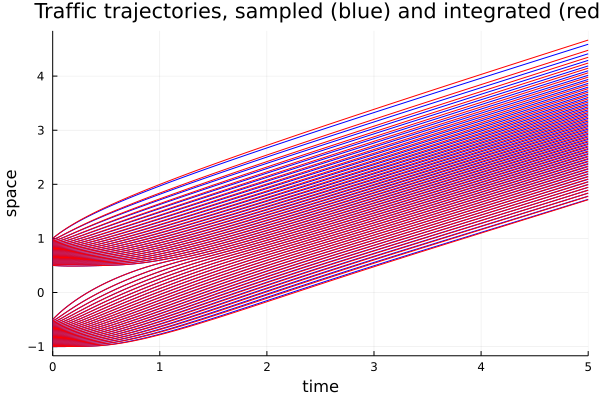

In [14]:
plot(title="Traffic trajectories, sampled (blue) and integrated (red)", legend=false)
plot!(ssol; color=:blue)
plot!(isol; color=:red)
plot!(xlabel="time", ylabel="space")
savefig("plots/trajectories.png")
plot!()

## Plot the density

Let us first compute a more refined solution.

In [15]:
n = 101
x0 = ArrayPartition(vcat(range(-1, -.5, length=n), range(.5, 1, length=n)))

sprob = ODEProblem(velocities_gen!, x0, tspan, smodel)
iprob = ODEProblem(velocities_gen!, x0, tspan, imodel)

abstol, reltol = 1e-7, 1e-7

@time ssol = solve(sprob, BS5(); abstol=abstol, reltol=reltol)
@time isol = solve(iprob, BS5(); abstol=abstol, reltol=reltol)

length.((ssol, isol))

  0.507735 seconds (5.36 k allocations: 5.627 MiB)
  0.486930 seconds (8.30 k allocations: 10.697 MiB)


(137, 136)

Now we can plot an animation of the density.

┌ Info: Saved animation to 
│   fn = /home/fstra/Documents/particles/ConservationLawsParticles.jl/examples/plots/traffic.gif
└ @ Plots /home/fstra/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/home/fstra/Documents/particles/ConservationLawsParticles.jl/examples/plots/traffic.gif")
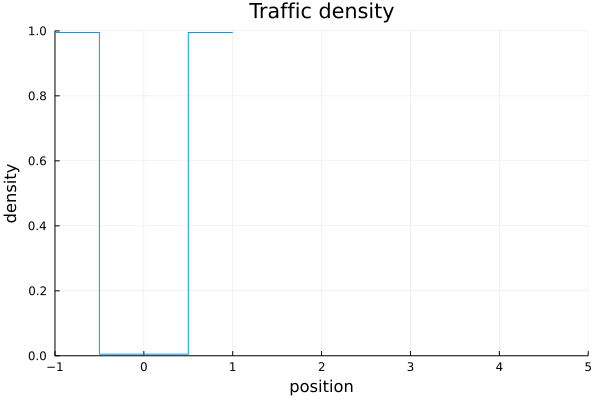

In [16]:
anim = @animate for t in range(tspan..., step=1/24)
    plot_density(isol(t); legend=false, xrange=(-1, 5), yrange=(0, 1),
        title="Traffic density", xlabel="position", ylabel="density")
end
gif(anim, "plots/traffic.gif")

We can translate the particles so that the barycenter stays at the origin.

In [17]:
barycenter(x::AbstractVector) = (sum(x) - (x[1] + x[end]) / 2) / (length(x) - 1)
recenter(x::AbstractVector) = x .- barycenter(x)

recenter (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /home/fstra/Documents/particles/ConservationLawsParticles.jl/examples/plots/traffic_centered.gif
└ @ Plots /home/fstra/.julia/packages/Plots/Awg62/src/animation.jl:104


Plots.AnimatedGif("/home/fstra/Documents/particles/ConservationLawsParticles.jl/examples/plots/traffic_centered.gif")
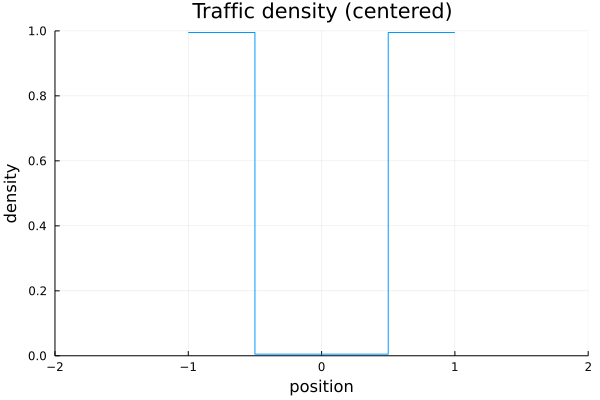

In [18]:
anim = @animate for t in range(tspan..., step=1/24)
    plot_density(recenter(isol(t)); legend=false, xrange=(-2, 2), yrange=(0, 1),
        title="Traffic density (centered)", xlabel="position", ylabel="density")
end
gif(anim, "plots/traffic_centered.gif")